In [22]:
from lammps import lammps
import numpy as np
lmp = lammps()
lmp.file("reax_ff_sim/ceo2_reaxff/ceo2_reaxff_bulk.lmp") # Fluorite CeO2 from https://next-gen.materialsproject.org/materials/mp-20194?chemsys=Ce-O

In [11]:
conv = 0.0433641 # eV to kcal/mol
nCeO2 = 4

# Initialize the volume
volume = lmp.get_thermo("vol")
volume_per_CeO2 = volume / nCeO2

E_CeO2 = lmp.get_thermo("pe")* conv / nCeO2
print("Energy per CeO2: ", E_CeO2)


Energy per CeO2:  -9.793358597990013


Code to scale the box and remap the coordinate according to its stretched form

In [2]:
import os

def scale_lammps_data(input_file, scale_factor, output_file_dir, output_file_template):
    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Find the line indices for box dimensions
    for i, line in enumerate(lines):
        if 'xlo xhi' in line:
            xlo_xhi_index = i
        elif 'ylo yhi' in line:
            ylo_yhi_index = i
        elif 'zlo zhi' in line:
            zlo_zhi_index = i

    # Parse box dimensions
    xlo, xhi = map(float, lines[xlo_xhi_index].split()[:2])
    ylo, yhi = map(float, lines[ylo_yhi_index].split()[:2])
    zlo, zhi = map(float, lines[zlo_zhi_index].split()[:2])

    # Calculate new box dimensions
    new_xhi = xhi * scale_factor
    new_yhi = yhi * scale_factor
    new_zhi = zhi * scale_factor

    # Replace box dimensions in the lines
    lines[xlo_xhi_index] = f"{xlo} {new_xhi} xlo xhi\n"
    lines[ylo_yhi_index] = f"{ylo} {new_yhi} ylo yhi\n"
    lines[zlo_zhi_index] = f"{zlo} {new_zhi} zlo zhi\n"

    # Find the start of the atoms section
    atoms_start = lines.index('Atoms\n') + 2

    # Scale the atom coordinates
    for i in range(atoms_start, len(lines)):
        parts = lines[i].split()
        if len(parts) == 6:
            id, type, charge = parts[:3]
            x, y, z = map(float, parts[3:])

            new_x = x * scale_factor
            new_y = y * scale_factor
            new_z = z * scale_factor

            lines[i] = f"{id} {type} {charge} {new_x} {new_y} {new_z}\n"

    # Determine the output file name
    output_file_name = f"{output_file_template}_{scale_factor:.3f}.lmp"
    output_file = os.path.join(output_file_dir, output_file_name)

    # Create the output directory if it doesn't exist
    os.makedirs(output_file_dir, exist_ok=True)

    # Write the scaled data to the output file
    with open(output_file, 'w') as file:
        file.writelines(lines)


Run this cell to scale the volume up from the initial volume. Volume has to be resetted by running the first cell before running this cell or other cell again.

We cannot scale further down from this for some reason due to an error of "Too many ghost atoms"

35.03202844448995
36.149988882186065
37.291484468894005
38.456760362415984
39.64606172055422
40.859633701110916
42.09772146188828
43.36057016068851
44.64842495531382
45.96153100356643
47.30013346324854
48.664477492162334
50.054808248110035
51.471370888893844
52.91441057231598
54.38417245617864
55.880901698284035
57.404843456434364
58.95624288843184
60.53534515207868
62.14239540517709
63.77763880552926
65.44132051093739
67.1336856792037
68.8549794681304


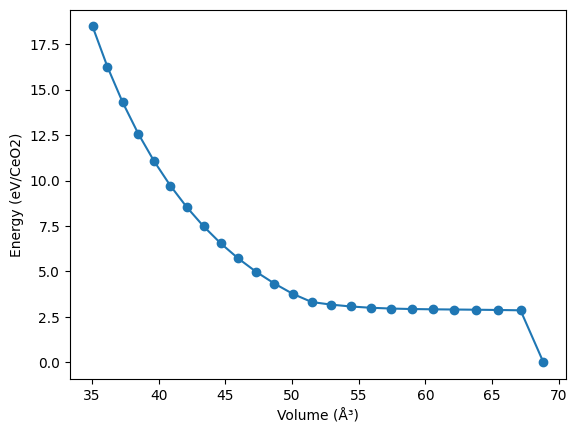

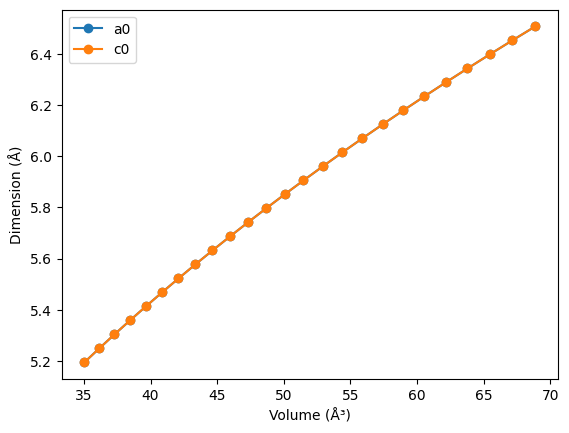

In [11]:
import numpy as np

from lammps import lammps
lmp = lammps()

# Initialize a list to store the volumes and energies
volumes = []
energies = []
a0_values = []
c0_values = []

start_scale = 0.95
end_scale = 1.2
step = 0.01

# Constants needed for calculations
conv = 0.0433641 # eV to kcal/mol
nCeO2 = 4

# Define the input file name
input_file = 'reax_ff_sim/ceo2_reaxff/geometry_file/ceo2_fluorite.lmp'

# Define the output directory and file template
output_file_dir = 'reax_ff_sim/ceo2_reaxff/geometry_file/fluorite_scaled'
output_file_template = 'ceo2_fluorite'

for scale_factor in np.arange(start_scale, end_scale, step):
    # Initialize Simulation
    lmp.command("clear")
    lmp.command("units real")
    lmp.command("dimension 3")
    lmp.command("boundary p p p")
    lmp.command("atom_style charge")
    lmp.command("atom_modify map array")

    # Create Atoms
    # Define supercell parameters
    lmp.command("variable nx equal 2")
    lmp.command("variable ny equal 2")
    lmp.command("variable nz equal 2")
    lmp.command("variable total_cells equal ${nx}*${ny}*${nz}")

    lmp.command("region box block 0 ${nx} 0 ${ny} 0 ${nz}")
    # Run the simulation
    filename = f"C:/Users/user/Documents/School/FFparamOpt/reax_ff_sim/ceo2_reaxff/geometry_file/fluorite_scaled/ceO2_fluorite_{scale_factor:.3f}.lmp"
    scale_lammps_data(input_file, scale_factor, output_file_dir, output_file_template)
    lmp.command(f"read_data {filename}")
    lmp.command("pair_style reaxff NULL checkqeq yes")  # Enable charge equilibration (QEq)
    lmp.command("pair_coeff * * C:/Users/user/Documents/School/FFparamOpt/reax_ff_sim/ffield.reax O Ce")
    lmp.command("fix qeq all qeq/reaxff 1 0.0 10.0 1.0e-6 reaxff")
    lmp.command("neighbor 2.0 bin")
    lmp.command("neigh_modify every 1 delay 0 check yes")

    # Increase buffer size for bonds
    lmp.command("comm_modify vel yes")

    # Define Settings
    lmp.command("compute eng all pe/atom")
    lmp.command("compute eatoms all reduce sum c_eng")

    # Add Electric Field
    # lmp.command("fix efield all efield 5.0 0.0 0.0 region box")

    # Run Minimization
    lmp.command("reset_timestep 0")
    # lmp.command("fix 1 all box/relax iso 1.0 vmax 5")
    lmp.command("thermo 10")
    lmp.command("thermo_style custom step pe lx ly lz press pxx pyy pzz c_eatoms")
    lmp.command("min_style cg")
    lmp.command("minimize 1e-25 1e-25 5000 10000")
    lmp.command(f"dump mydmp all atom 1 dump_{scale_factor:.3f}.lammpstrj")

    # Get the current volume and energy
    volume = lmp.get_thermo("vol")
    energy = lmp.get_thermo("pe")  # Use the potential energy as the total energy

    volumes_per_CeO2 = volume / nCeO2
    print(volumes_per_CeO2)
    energie_per_CeO2 = energy * conv / nCeO2

    # Store the volume and energy
    volumes.append(volumes_per_CeO2)
    energies.append(energie_per_CeO2)

    a0 = lmp.get_thermo("lx")
    a0_values.append(a0)

    c0 = lmp.get_thermo("lz")
    c0_values.append(c0)

# Convert the lists to numpy arrays
volumes = np.array(volumes)
energies = np.array(energies)
a0_values = np.array(a0_values)
c0_values = np.array(c0_values)

# Shift the energy scale so that the minimum energy is at 0 eV/CeO2
energies -= energies.min()

# Plot the energy-volume relationship
import matplotlib.pyplot as plt
plt.plot(volumes, energies, 'o-')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (eV/CeO2)')
plt.show()

# Plot the a0 and c0 values
plt.figure()
plt.plot(volumes, a0_values, 'o-', label='a0')
plt.plot(volumes, c0_values, 'o-', label='c0')
plt.xlabel('Volume (Å³)')
plt.ylabel('Dimension (Å)')
plt.legend()
plt.show()

Because we have to generate some structures of our own from ase and pymatgen which results in chargeless structure, we have to have a function that add charges.

In [4]:
def add_charges_to_atoms(input_file, output_file):
    # Define the charges for each atom type
    atom_charges = {
        1: 4.0,  # Ce
        2: -2.0  # O
    }

    # Read the file and store its contents
    with open(input_file, "r") as file:
        lines = file.readlines()

    # Find the line number where atom information starts
    atom_info_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Atoms"):
            atom_info_line = i + 1
            break

    # If the line number is found, add charges to each atom
    if atom_info_line is not None:
        # Iterate through atom lines and add charges
        for i in range(atom_info_line, len(lines)):
            atom_line = lines[i].split()
            if len(atom_line) < 2:
                continue  # Skip lines that do not have enough elements
            atom_index = atom_line[0]
            atom_type = int(atom_line[1])
            charge = atom_charges.get(atom_type)
            if charge is not None:
                # Modify the line to include charge
                lines[i] = f"         {atom_line[0]}         {atom_line[1]}   {charge}        {atom_line[2]}       {atom_line[3]}       {atom_line[4]}\n"

    # Write the modified contents back to the output file
    with open(output_file, "w") as file:
        file.writelines(lines)

Create rutile structure. This cell has gone awry. The energy exploded and the lattice constant becomes way off

In [13]:
from ase import Atoms
from ase.build import bulk, make_supercell
from ase.io import write
import numpy as np

# Define lattice parameters for rutile CeO2
a = 5.078  # Angstrom
c = 3.567  # Angstrom

# Create the CeO2 unit cell with 12 atoms
rutile_CeO2 = Atoms(
    symbols='Ce2O4',
    positions=[
        # Original 6 atoms from Shengming
        [0.0000, 0.0000, 0.0000],                      # Ce1
        [2.5673285, 2.5673285, 1.8182100],             # Ce2
        [0.9619266, 4.1727304, 1.8182100],             # O1
        [4.1727304, 0.9619266, 1.8182100],             # O2
        [3.5292551, 3.5292551, 0.0000],                # O3
        [1.6054019, 1.6054019, 0.0000],                # O4
    ],
    cell=[
        [a, 0, 0],
        [0, a, 0],
        [0, 0, c]
    ],
    pbc=True
)


# Create the supercell
rutile_CeO2_supercell = make_supercell(rutile_CeO2, [[1,0,0],[0,1,0],[0,0,1]])

# Define the CIF filename
cif_filename = "CeO2_rutile.cif"

# Write the supercell to a CIF file
write(cif_filename, rutile_CeO2_supercell, format='cif')

Manually call atomsk to transform the cif file to lammps

In [10]:
input_file = "CeO2_rutile.lmp"
output_file = "CeO2_rutile_with_charges.lmp"
add_charges_to_atoms(input_file, output_file)

In [12]:
lmp.file("reax_ff_sim/ceo2_reaxff/ceo2_reaxff_bulk_rutile.lmp")
volume = lmp.get_thermo("vol")
energy = lmp.get_thermo("pe")  # Use the potential energy as the total energy

nCeO2 = 6

volumes_per_CeO2 = volume / nCeO2
energie_per_CeO2 = energy * conv / nCeO2
a0 = lmp.get_thermo("lx")
c0 = lmp.get_thermo("lz")

print("Volume per CeO2: ", volumes_per_CeO2)
print("Energy per CeO2: ", energie_per_CeO2)
print("Lattice constant a0: ", a0)
print("Lattice constant c0: ", c0)


Volume per CeO2:  15.329826938000002
Energy per CeO2:  -4.665525336203085
Lattice constant a0:  5.078
Lattice constant c0:  3.567


Perform Energy-Volume scan on rutile

14.428310475430097
16.167611264328645
18.041358448373977
20.054557270818766
22.212212974915545
24.519330803916976
26.98091600107574
29.60197380964435
32.38750947287548
35.34252823402178
38.47203533633583
41.781036023070236
45.27453553747768
48.95753912281075
52.83505202232203
56.912079479264214
61.19362673688988
65.68469903845163
70.39030162720208
75.315439746394


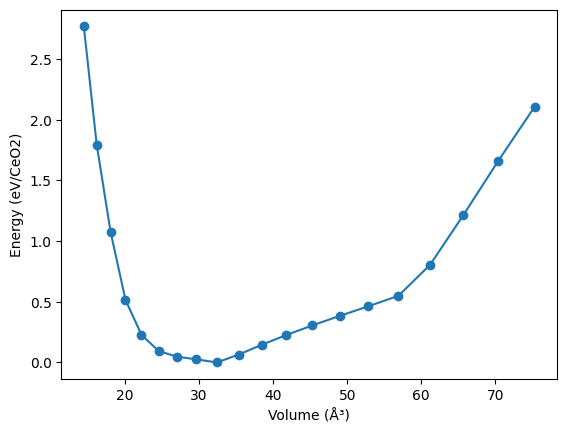

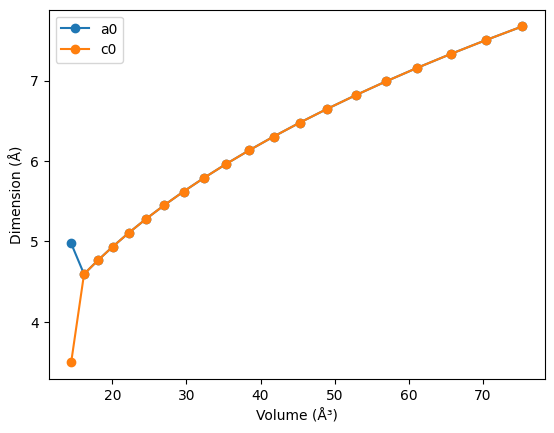

In [13]:
# Initialize a list to store the volumes and energies
volumes = []
energies = []
a0_values = []
c0_values = []

# Get the original box size
original_box = lmp.get_thermo("vol")

# Calculate the side length of the original box
original_box_dim = np.cbrt(original_box)

# Loop over a range of volumes
for scale_factor in np.linspace(0.98, 1.7, 20):  # Adjust the range and step size as needed
    # Scale the box size
    lmp.command(f"change_box all x scale {scale_factor} y scale {scale_factor} z scale {scale_factor} remap")

    # Perform energy minimization
    lmp.command("minimize 1.0e-4 1.0e-6 100 1000")

    # Get the current volume and energy
    volume = lmp.get_thermo("vol")
    energy = lmp.get_thermo("pe")  # Use the potential energy as the total energy

    volumes_per_CeO2 = volume / nCeO2
    print(volumes_per_CeO2)
    energie_per_CeO2 = energy * conv / nCeO2

    # Store the volume and energy
    volumes.append(volumes_per_CeO2)
    energies.append(energie_per_CeO2)

    a0 = lmp.get_thermo("lx")
    a0_values.append(a0)

    c0 = lmp.get_thermo("lz")
    c0_values.append(c0)

    # Reset the box size to its original value
    lmp.command(f"change_box all x final 0 {original_box_dim} y final 0 {original_box_dim} z final 0 {original_box_dim} remap")

    if volume_per_CeO2 > 80:
        break

# Convert the lists to numpy arrays
volumes = np.array(volumes)
energies = np.array(energies)
a0_values = np.array(a0_values)
c0_values = np.array(c0_values)

# Shift the energy scale so that the minimum energy is at 0 eV/CeO2
energies -= energies.min()

# Plot the energy-volume relationship
import matplotlib.pyplot as plt
plt.plot(volumes, energies, 'o-')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (eV/CeO2)')
plt.show()

# Plot the a0 and c0 values
plt.figure()
plt.plot(volumes, a0_values, 'o-', label='a0')
plt.plot(volumes, c0_values, 'o-', label='c0')
plt.xlabel('Volume (Å³)')
plt.ylabel('Dimension (Å)')
plt.legend()
plt.show()

Perform NVE on Ce2O3 on a structure I found from material project (according to Gunjana's recommendation). Calculate the lattice constants and also the energy per formula unit. The lattice constants are similar to that of the literature, with the exception of c_0 which is more in tandem with the information of the geometry file I downloaded from https://next-gen.materialsproject.org/materials/mp-561149?formula=Ce2O3

In [44]:
lmp.file("reax_ff_sim/ceo2_reaxff/ce2o3_reaxff_bulk.lmp")
a_0 =  lmp.get_thermo("lx")
c_0 =  lmp.get_thermo("lz")
print("Lattice constant a_0 = ", a_0)
print("Lattice constant c_0 = ", c_0)
E_Ce2O3 = lmp.get_thermo("pe") * conv / 1 # Since there is only one Ce2O3 unit in the simulation cell

print("Energy of Ce2O3 per unit = ", E_Ce2O3)

Lattice constant a_0 =  3.87098395
Lattice constant c_0 =  5.89577273
Energy of Ce2O3 per unit =  -19.925655168180477


Calculate energy of CeO2 -> Ce2O3 By giving
E = E(Ce2O3) + 1/2 E(O2) − 2E(CeO2) when each E is an energy per 1 unit of Ceria or Oxygen. This number is way off from the literature (2.5 eV/Ce2O3).

The geometry of O2 was retrieved from https://next-gen.materialsproject.org/materials/mp-607540?formula=O

In [42]:
lmp.file("reax_ff_sim/o2_reaxff/o2_reaxff.lmp")
E_O2 = 2 * lmp.get_thermo("pe") * conv # Since there is half O2 unit in the simulation cell
print("Energy of O2 per unit = ", E_O2)
E = E_Ce2O3 + E_O2 / 2 - E_CeO2
print("Energy CeO2 -> Ce2O3= ", E)

Energy of O2 per unit =  -0.028874936899001592
Energy CeO2 -> Ce2O3=  -10.146734038639964


Create a CeO2 (111) slab using pymatgen

In [1]:
import pymatgen as mg
from pymatgen.core.surface import SlabGenerator
from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read, write
from ase.build import surface, make_supercell, sort
from pymatgen.io.ase import AseAtomsAdaptor

structure = read("reax_ff_sim/ceo2_reaxff/geometry_file/CeO2_fluorite.cif")

slab = surface(structure, (1,1,1), layers=7, vacuum=10.0)
slab.center(vacuum=40.0, axis=2)

# Create the supercell
supercell = make_supercell(slab, [[4,0,0],[0,4,0],[0,0,1]])
write('reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab.cif', slab, format='cif')


Add charges to the lammps file

In [2]:
input_file = "reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab.lmp"
output_file = "reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab_with_charges.lmp"
add_charges_to_atoms(input_file, output_file)

Charges have been added to the atom entries in the file.


Run energy minimization on the slab to get E[CeO2 slab]

In [7]:
lmp.file("reax_ff_sim/ceo2_slab_reaxff/ceo2_slab_reaxff.lmp")   # Run the simulation
E_slab = lmp.get_thermo("pe") * conv / 1
print(E_slab)

-554.8505657021614


FInd the position of oxygen to form a vacancy

In [8]:
# Get the positions of all the atoms
positions = slab.get_positions()

# Calculate the average x, y, and z coordinates to move the O above the slab at the center of the vacuum region
center_x = np.mean(positions[:, 0])
center_y = np.mean(positions[:, 1])
center_z = np.mean(positions[:, 2])

print(f"Center of the slab: ({center_x}, {center_y}, {center_z})")

center = np.array([center_x, center_y, center_z])


# Initialize the minimum distance and the index of the closest oxygen atom
min_distance = np.inf
closest_oxygen_index = None

# Get the symbols of all the atoms
symbols = slab.get_chemical_symbols()

# Iterate over all the atoms
for i, (position, symbol) in enumerate(zip(positions, symbols)):
    # If the atom is an oxygen atom
    if symbol == 'O':
        # Calculate the distance to the center
        distance = np.linalg.norm(position - center)
        
        # If the distance is smaller than the current minimum distance
        if distance < min_distance:
            # Update the minimum distance and the index of the closest oxygen atom
            min_distance = distance
            closest_oxygen_index = i

print(f"The closest oxygen atom to the center is atom number {closest_oxygen_index + 1}.")

Center of the slab: (5.937180799510274, 2.6838071799635537, 50.52211310451138)
The closest oxygen atom to the center is atom number 45.


Manually add 40 Angstrom to the value of coordinate z of atom number 45 (O29 in cif) in file called "ceo2_slab_vacancy_reaxff.lmp"  and run the simulation. From VESTA, I locate that Cerium atoms around O29 are Ce20 (Atom: 52), Ce19(Atom: 51), Ce17(Atom: 49), Ce14(Atom: 38)

In [9]:
lmp.file("reax_ff_sim/ceo2_slab_reaxff/ceo2_slab_vacancy_reaxff.lmp")   # Run the simulation
E_slab_vacancy = lmp.get_thermo("pe") * conv
print(E_slab_vacancy)

-555.5782137987813


Calculate E_vac

In [10]:
D_e_O2 = 5.45 # Dissociation energy of O2 molecule from literature in eV
E_vac = E_slab_vacancy - E_slab - D_e_O2 / 2
print("Vacancy formation energy = ", E_vac)

Vacancy formation energy =  -3.452648096619987


Calculate the structural deformation around the oxygen vacancy O29

In [11]:
import numpy as np

# Define the cerium atoms read from final_geometry.lmp manually
Ce38 = np.array([5.107938339022216, 3.277060061719677, 49.15308802199843])
Ce49 = np.array([3.789872573650163, 4.6981695823644705, 52.69046389503382])
Ce51 = np.array([3.645941751278667, 2.4329634989701208, 56.166428222628234])
Ce52 = np.array([9.493695473507687, 5.72259380455767, 56.19020927978149])

# Create a list of the points considering how Ce is labeled in the literature
points = [Ce38, Ce49, Ce51, Ce52]

# Define the pairs of points for which to calculate distances
pairs = [(1, 3), (2, 4), (1, 2), (2, 3), (3, 4)]

# Calculate the distances between the specified pairs of points
for pair in pairs:
    dist = np.linalg.norm(points[pair[0]-1] - points[pair[1]-1])
    print(f"The distance between point {pair[0]} and point {pair[1]} is {dist} Angstrom.")

The distance between point 1 and point 3 is 7.2136588358189995 Angstrom.
The distance between point 2 and point 4 is 6.769878759477001 Angstrom.
The distance between point 1 and point 2 is 4.033593645701809 Angstrom.
The distance between point 2 and point 3 is 4.151409723043989 Angstrom.
The distance between point 3 and point 4 is 6.7095794713202945 Angstrom.
